In [174]:
import yfinance as yf
import pandas as pd
import sklearn
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt

import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 5]

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

timeframe = '1h'

In [175]:
# Get the stock data using yahoo API:
# we have tweets from 20201-06-24 to 2021-07-26
style.use('ggplot')

# get 2014-2018 data to train our model
start_train = datetime.datetime(2021,6,24)
end_train = datetime.datetime(2021,7,17)

# get 2019 data to test our model on 
start_test = datetime.datetime(2021,7,18)
end_test = datetime.datetime(2021,7,27)


In [176]:
# import MexBIT dataset

df_xbt = pd.read_csv('XBTUSD-1h-data.csv', index_col=['timestamp'], parse_dates=['timestamp'])
train_df = df_xbt.resample(timeframe).mean()[start_train:end_train]
test_df = df_xbt.resample(timeframe).mean()[start_test:end_test]

In [178]:
# import tweets dataset

df = pd.read_csv('tweet_dset.csv')
df = df[df['ticker'] == '$BTC']

In [179]:
df['ctime'] = pd.to_datetime(df['date_time'], unit='s')
df = df.set_index('ctime')
mean_sentiment = df['sentiment'].resample(timeframe).mean()

In [180]:
# train-test split

splitter = int(len(mean_sentiment)*0.9)
train_sentiment = mean_sentiment[:splitter]
test_sentiment = mean_sentiment[splitter:]

In [182]:
# Create train set of adj close prices data:

train_data = train_df.loc[:,'close'].to_numpy()
print(train_data.shape)


# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

(553,)


In [184]:
# Function to create a dataset to feed into an LSTM

def create_dataset(dataset, sentiment, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        s = train_sentiment[i:(i + look_back)]
        dataX.append( np.vstack([a, s]).ravel('F'))
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [185]:
# define time_steps = number of observations from which we imply the future observation

t = 10

In [186]:
# Create the data to train our model on (merge sentiment values to returns dataset)

time_steps = t
X_train, y_train = create_dataset(train_data, train_sentiment.values, time_steps)
X_train[0]

array([0.54225352, 0.30503158, 0.46294433, 0.00488864, 0.37022133,
       0.08274257, 0.3445674 , 0.11866897, 0.36267606, 0.13005701,
       0.35135815, 0.060175  , 0.42630785, 0.05831644, 0.43117036,
       0.13400073, 0.4038397 , 0.14624969, 0.49279007, 0.12211357])

In [187]:
# reshape it [samples, time steps, features]

X_train = np.reshape(X_train, (X_train.shape[0], t, 2))
X_train[0]

# print(X_train.shape)

array([[0.54225352, 0.30503158],
       [0.46294433, 0.00488864],
       [0.37022133, 0.08274257],
       [0.3445674 , 0.11866897],
       [0.36267606, 0.13005701],
       [0.35135815, 0.060175  ],
       [0.42630785, 0.05831644],
       [0.43117036, 0.13400073],
       [0.4038397 , 0.14624969],
       [0.49279007, 0.12211357]])

In [188]:
# Visualizing our data with prints: 

print('X_train:')
print(str(scaler.inverse_transform(X_train[0][:, 0:1])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

(543, 10, 2)
X_train:
[[33654. ]
 [33181. ]
 [32628. ]
 [32475. ]
 [32583. ]
 [32515.5]
 [32962.5]
 [32991.5]
 [32828.5]
 [33359. ]]


y_train: [[33255.]]



In [189]:
# Build the model 

model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 2)))
model.add(Dropout(0.2))

# model.add(LSTM(units = 100, return_sequences = True))
# model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.optimizer.lr.assign(0.001)

# Fitting the model to the Training set (original batch = 32)
history = model.fit(X_train, y_train, epochs = 300, batch_size = 32, validation_split=.10)

Epoch 1/300
16/16 [==============================] - 1s 48ms/step - loss: 0.0773 - val_loss: 0.0030
Epoch 2/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0180 - val_loss: 0.0144
Epoch 3/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0107 - val_loss: 0.0118
Epoch 4/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0096 - val_loss: 0.0055
Epoch 5/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0087 - val_loss: 0.0041
Epoch 6/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0094 - val_loss: 0.0058
Epoch 7/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0081 - val_loss: 0.0050
Epoch 8/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0078 - val_loss: 0.0034
Epoch 9/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0075 - val_loss: 0.0028
Epoch 10/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0085 - val_loss: 0.0030
E

16/16 [==============================] - 0s 10ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 163/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 164/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0028 - val_loss: 9.4614e-04
Epoch 165/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 166/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 167/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 0.0010
Epoch 168/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 169/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 8.4876e-04
Epoch 170/300
16/16 [==============================] - 0s 9ms/step - loss: 0.0027 - val_loss: 7.6610e-04
Epoch 171/300
16/16 [==============================] - 0s 10ms/step - loss: 0.0027 - v

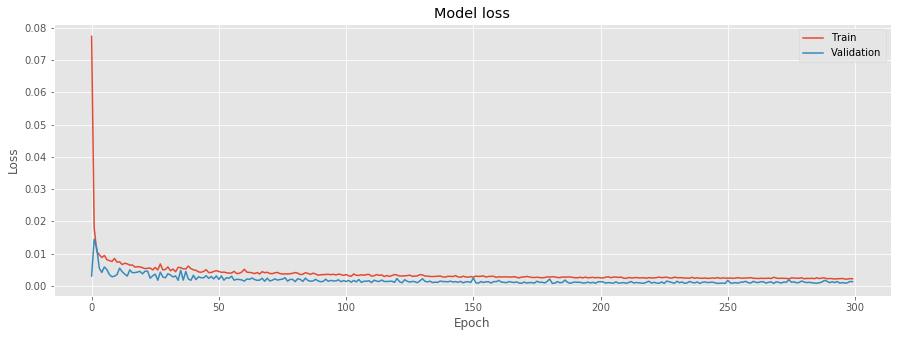

In [190]:
# Plot training & validation loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [191]:
# Get the stock prices for 2019 to have our model make the predictions

test_data = test_df['close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = t
X_test, y_test = create_dataset(test_data, test_sentiment.values, time_steps)

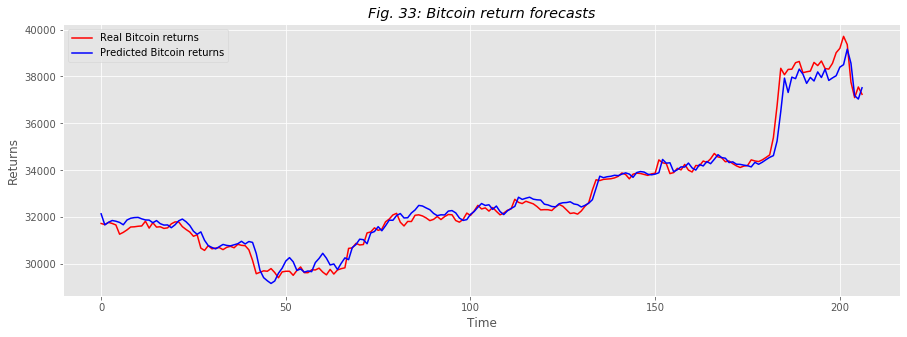

In [193]:
# store the original vals for plotting the predictions

y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], t, 2))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)


# plot the results 
plt.plot(org_y, color = 'red', label = 'Real Bitcoin returns')
plt.plot(predicted_y, color = 'blue', label = 'Predicted Bitcoin returns')
plt.title('Fig. 33: Bitcoin return forecasts', style = 'italic')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [195]:
# Mean Squared Error

test_mse = sum(predicted_y - org_y)**2 / len(org_y)
test_mse

array([279019.18799366])

In [196]:
# hit ratio

predictions_updown = list()
real_updown = list()

prev_price = test_data[(time_steps-1)]
for t in range(len(test_data)-time_steps):
    predictions_updown.append(predicted_y[t] - prev_price)
    real_updown.append(test_data[time_steps + t] - prev_price)
    if t+1 < len(test_data) -(time_steps-1):
        prev_price = test_data[(time_steps-1) + t+1]
        
correct_count = 0
for i in range(len(real_updown)):
    if ((real_updown[i] > 0) and (predictions_updown[i] > 0)) or(( real_updown[i] <= 0) and (predictions_updown[i] <= 0)):
        correct_count += 1
    
print(correct_count / len(real_updown))

In [ ]:
# opposite hit ratio

1-(correct_count/( len(diff)-2))